In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from matplotlib.colors import to_rgba,to_rgb

In [2]:
def my_pinv(X,rank):
    U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    Σ[rank:] = 0.0
    return Vh.T.conj().dot(np.linalg.pinv(np.diag(Σ))).dot(U.T.conj())
def nonzero_filter(eigs):
    return eigs[np.abs(eigs)>1e-12]

/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part


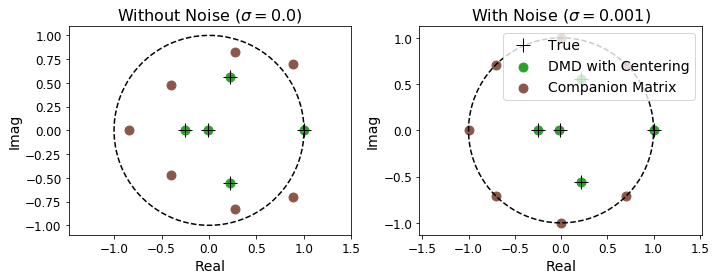

In [3]:
# Run all the DMD's
np.random.seed(0)
m_features = 10
n_time_steps = 8
num_eigenvals = 5

x0 = np.random.randn(m_features)

A = np.random.randn(m_features,m_features) / np.sqrt(m_features) 
U,Σ,Vh = np.linalg.svd(A)
sig = np.zeros((m_features,m_features))
sig[range(num_eigenvals),range(num_eigenvals)] = Σ[:num_eigenvals]
A_trunc = U.dot(sig).dot(Vh)
trunc_eigenvals = np.linalg.eig(A_trunc)[0]

# Offset
b =  np.random.randn(m_features) * 1.0

#print('A_trunc',A_trunc)
#print('b',b)
t = np.arange(n_time_steps)
Y = np.zeros((m_features,n_time_steps+1),dtype=complex)
Y[:,0] = x0
for i in range(1,n_time_steps+1):
    Y[:,i] = A_trunc.dot(Y[:,i-1])+b
Y = Y[:,1:]

plt.figure(figsize=(10,4))
for _j, _σ in enumerate((0.0,1e-3)):

# Noise level

    Y += np.random.randn(*Y.shape)*_σ

    # Centered solution (related to centering your data)
    centered_alg = {}
    μ1 = Y[:,:-1].mean(axis=1)
    μ2 = Y[:,1:].mean(axis=1)
    μ = Y.mean(axis=1)
    centered_alg['A'] = (Y[:,1:]-μ2[:,np.newaxis]).dot(my_pinv(Y[:,:-1] - μ1[:,np.newaxis],num_eigenvals))
    centered_alg['b'] = μ2 - centered_alg['A'].dot(μ1)
    centered_alg['label'] = 'DMD with Centering'
    centered_alg['eig'] = np.linalg.eig(centered_alg['A'])[0]
    centered_alg['color'] = 'tab:green'
    

    # Using companion matrix
    X1 = Y[:,:-1]
    X2 = Y[:,1:]
    companion_cent = {}
    d = np.ones(n_time_steps-1)[:,np.newaxis]
    μ = Y.mean(axis=1)
    companion_cent = {}
    companion_cent['C'] = np.zeros((n_time_steps-1,n_time_steps-1))
    companion_cent['C'][np.arange(1,n_time_steps-1),np.arange(n_time_steps-2)] = 1
    companion_cent['C'][:,-1] = np.linalg.pinv(Y[:,:-1] - μ[:,np.newaxis]).dot(Y[:,-1] - μ)
    companion_cent['eig'] = np.linalg.eig(companion_cent['C'])[0]
    companion_cent['label'] = 'Companion Matrix'
    companion_cent['color'] = 'tab:brown'
    # Make tuple of all algorithms
    algs = (centered_alg,companion_cent)

    plt.subplot(1,2,_j+1)
    for method in algs:
        plt.scatter(np.real(nonzero_filter(method['eig'])),np.imag(nonzero_filter(method['eig'])),
                    label=method['label'],c=(*to_rgb(method['color']),1.0),
                            s=80,edgecolors=(*to_rgb(method['color']),1.0))

    true_eig,_ = np.linalg.eig(A_trunc)
    plt.plot(np.real(nonzero_filter(true_eig)),np.imag(nonzero_filter(true_eig)),'k+',markersize=14,label='True')

    temp = np.linspace(0,1,100)
    x = np.cos(2*np.pi*temp)
    y = np.sin(2*np.pi*temp)
    plt.plot(x,y, 'k--')
    plt.axis('equal')

    plt.title([r'Without Noise $(\sigma = 0.0)$',r'With Noise $(\sigma = 0.001)$'][_j],fontsize=16)
    plt.ylabel('Imag',fontsize=14)
    plt.xlabel('Real',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
plt.legend(loc=1,fontsize=14)
plt.tight_layout()
plt.savefig('../Writeup/Figures/companion_comparison.png',dpi=300)